# Load Parquet Files into DataFrames

In [2]:
import pandas as pd
import os
# Directory containing Parquet files
parquet_directory = 'ExtractedFiles'

# Initialize a dictionary to hold the DataFrames
dataframes = {}

# Check if the directory exists
if os.path.exists(parquet_directory):
    # List all Parquet files in the directory
    parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith('.parquet')]

    # Process each Parquet file
    for parquet_file in parquet_files:
        filepath = os.path.join(parquet_directory, parquet_file)
        # Load the Parquet file into a DataFrame
        df = pd.read_parquet(filepath)
        
        # Add the DataFrame to the dictionary
        # Use the filename (without the extension) as the key
        key = os.path.splitext(parquet_file)[0]
        dataframes[key] = df

    print("Loaded DataFrames from Parquet files.")
else:
    print(f"Directory does not exist: {parquet_directory}")

# Iterate through each key, value pair in the dataframes dictionary
for key, df in dataframes.items():
    print(f"Information for DataFrame: {key}")
    # Use the info() method to print detailed information about the DataFrame
    df.info()
    #df.head()
    print("\n")  # Add a newline for better readability between DataFrame infos

# Iterate through each key, value pair in the dataframes dictionary
for key, df in dataframes.items():
    print(f"Head of DataFrame '{key}':")
    print(df.head())  # Print the first few rows of the DataFrame
    print("-" * 40)  # Print a separator for readability


Loaded DataFrames from Parquet files.
Information for DataFrame: activity
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20472180 entries, 0 to 20472179
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   EntityNumber    object
 1   ActivityGroup   int64 
 2   NaceVersion     int64 
 3   NaceCode        int64 
 4   Classification  object
dtypes: int64(3), object(2)
memory usage: 781.0+ MB


Information for DataFrame: address
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821223 entries, 0 to 2821222
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   EntityNumber      object
 1   TypeOfAddress     object
 2   CountryNL         object
 3   CountryFR         object
 4   Zipcode           object
 5   MunicipalityNL    object
 6   MunicipalityFR    object
 7   StreetNL          object
 8   StreetFR          object
 9   HouseNumber       object
 10  Box               object
 11  ExtraAddressInfo  o

# Filtered DataFrame

In [3]:
import pandas as pd
import os
from functools import reduce

# Filtering for 'OfficialName'
official_name_df = dataframes['denomination'][
    (dataframes['denomination']['TypeOfDenomination'] == 1) & 
    (dataframes['denomination']['Language'] == 2)
][['Denomination', 'EntityNumber']].copy()  # Assuming 'Denomination' is the correct column to use

# Renaming column as per requirement
official_name_df.rename(columns={'Denomination': 'OfficialName'}, inplace=True)


abbreviation_df = dataframes['denomination'][
    (dataframes['denomination']['TypeOfDenomination'] == 2) & 
    (dataframes['denomination']['Language'] == 2)
][['Denomination', 'EntityNumber']].copy()  


abbreviation_df.rename(columns={'Denomination': 'Abbreviation'}, inplace=True)

tradeName_df = dataframes['denomination'][
    (dataframes['denomination']['TypeOfDenomination'] == 3) & 
    (dataframes['denomination']['Language'] == 2)
][['Denomination', 'EntityNumber']].copy()  

tradeName_df.rename(columns={'Denomination': 'TradeName'}, inplace=True)


zipcode_df = dataframes['address'][
    (dataframes['address']['TypeOfAddress'] == "REGO")
][['Zipcode', 'EntityNumber']].copy()  

zipcode_df.rename(columns={'Zipcode': 'ZipCode'}, inplace=True)


Municipality_df = dataframes['address'][
    (dataframes['address']['TypeOfAddress'] == "REGO")
][['MunicipalityNL', 'EntityNumber']].copy()  

Municipality_df.rename(columns={'MunicipalityNL': 'Municipality'}, inplace=True)


Street_df = dataframes['address'][
    (dataframes['address']['TypeOfAddress'] == "REGO")
][['StreetNL', 'EntityNumber']].copy()  

Street_df.rename(columns={'StreetNL': 'Street'}, inplace=True)


HouseNumber_df = dataframes['address'][
    (dataframes['address']['TypeOfAddress'] == "REGO")
][['HouseNumber', 'EntityNumber']].copy()  

HouseNumber_df.rename(columns={'HouseNumber': 'HouseNumber'}, inplace=True)

Email_df = dataframes['contact'][
    (dataframes['contact']['EntityContact'].isin(['ENT', 'EST'])) & 
    (dataframes['contact']['ContactType'] == 'EMAIL')
][['Value', 'EntityNumber']].copy()

Email_df.rename(columns={'Value': 'Email'}, inplace=True)

Tel_df = dataframes['contact'][
    (dataframes['contact']['EntityContact'].isin(['ENT', 'EST'])) & 
    (dataframes['contact']['ContactType'] == 'TEL')
][['Value', 'EntityNumber']].copy()

Tel_df.rename(columns={'Value': 'TEL'}, inplace=True)

URL_df = dataframes['contact'][
    (dataframes['contact']['EntityContact'].isin(['ENT', 'EST'])) & 
    (dataframes['contact']['ContactType'] == 'WEB')
][['Value', 'EntityNumber']].copy()

URL_df.rename(columns={'Value': 'URL'}, inplace=True)


# Combining the filtered DataFrames
# Assuming df_list is a list of your DataFrames
df_list = [official_name_df, abbreviation_df, tradeName_df,zipcode_df, Municipality_df, Street_df, HouseNumber_df, Email_df, Tel_df, URL_df]

# Using reduce to merge all DataFrames in the list based on 'EntityNumber'
combined_df = reduce(lambda left, right: pd.merge(left, right, on='EntityNumber', how='left'), df_list)

# Now, 'EntityNumber' can be set as the index in the combined DataFrame
combined_df.set_index('EntityNumber', inplace=True)



# Filtering 
If column CountryNL has a value, it means that the business is active in the country. We only want belgian businesses.

In [4]:
# Step 1: Identify rows in 'address' DataFrame with missing 'CountryNL' values
missing_country_nl = dataframes['address']['CountryNL'].isna()

# Extract 'EntityNumber' for rows where 'CountryNL' is missing
missing_entities = dataframes['address'][missing_country_nl]['EntityNumber']

# Step 2: Filter these 'EntityNumber's out of your main dataset 'final_df'
# Assuming 'final_df' has 'EntityNumber' as its index or a column
if 'EntityNumber' in combined_df.columns:
    # If 'EntityNumber' is a column in 'final_df'
    final_df_filtered = combined_df[combined_df['EntityNumber'].isin(missing_entities)]
else:
    # If 'EntityNumber' is the index in 'final_df'
    final_df_filtered = combined_df[combined_df.index.isin(missing_entities)]

# Filtering on URL
We make a .parquet file conatining the rows with a URL

In [5]:
filtered_df_with_url = final_df_filtered[final_df_filtered['URL'].notna()]

# Filtering on unique EntityNumber
Delete all duplicates

In [6]:
# Resetting the index to make 'EntityNumber' a column
df_reset = filtered_df_with_url.reset_index()

# Dropping duplicate 'EntityNumber' values, keeping the first occurrence
df_final = df_reset.drop_duplicates(subset='EntityNumber', keep='first')

# Optionally, setting 'EntityNumber' as the index again
#df_final = df_deduplicated.set_index('EntityNumber')


In [7]:
print(df_final.info())
print(df_final.head(50))

<class 'pandas.core.frame.DataFrame'>
Index: 17239 entries, 0 to 18552
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   EntityNumber  17239 non-null  object
 1   OfficialName  17239 non-null  object
 2   Abbreviation  2460 non-null   object
 3   TradeName     454 non-null    object
 4   ZipCode       17239 non-null  object
 5   Municipality  17239 non-null  object
 6   Street        17239 non-null  object
 7   HouseNumber   17239 non-null  object
 8   Email         15254 non-null  object
 9   TEL           5611 non-null   object
 10  URL           17239 non-null  object
dtypes: object(11)
memory usage: 1.6+ MB
None
    EntityNumber                                       OfficialName  \
0   0201.310.929                                                IGL   
1   0202.239.951                                           PROXIMUS   
2   0203.201.340                          Nationale Bank van België   
3   0206.460.639  In

# Analyse and visualize the final dataframe

        EntityNumber OfficialName Abbreviation              TradeName ZipCode  \
count          17239        17239         2460                    454   17239   
unique         17239        17231         2407                    452     566   
top     0201.310.929        BOONE     O.C.M.W.  besloten vennootschap    9000   
freq               1            2           14                      2     491   

       Municipality          Street HouseNumber          Email           TEL  \
count         17239           17239       17239          15254          5611   
unique          353            8980        1386          14915          5459   
top       Antwerpen  Stationsstraat           1  info@storm.be  014/37.75.73   
freq           1638             111         531             41            15   

                  URL  
count           17239  
unique          16734  
top     WWW.EQUANS.BE  
freq               53  
<class 'pandas.core.frame.DataFrame'>
Index: 17239 entries, 0 to 18552
Da

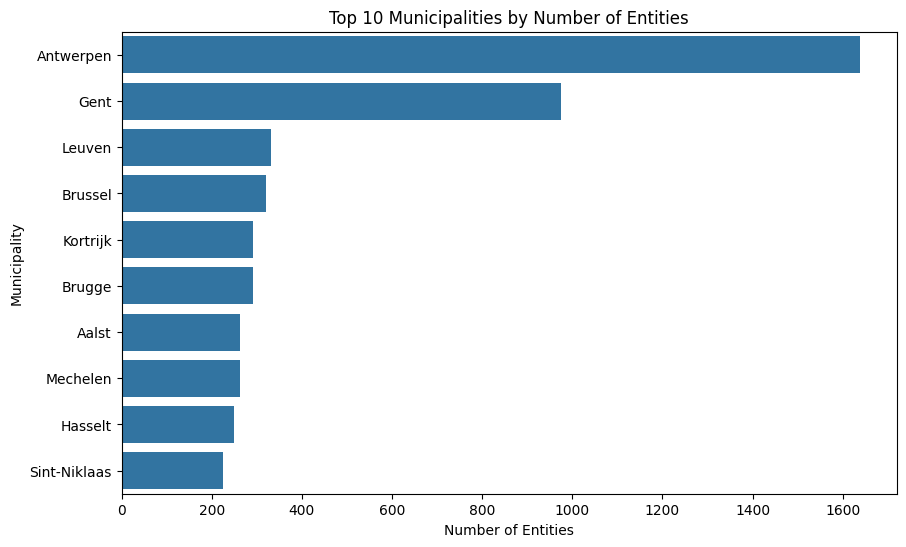

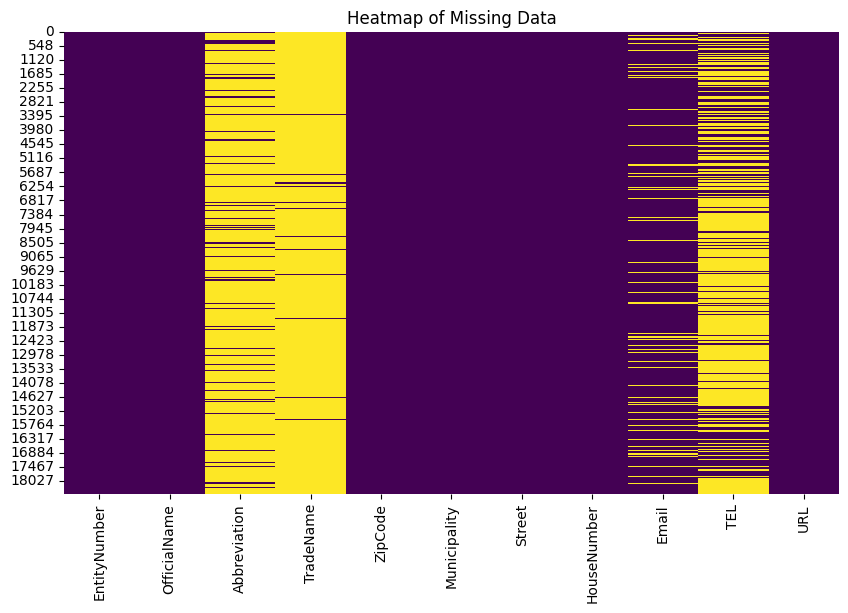

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics for numerical columns and info
print(df_final.describe())
print(df_final.info())

# Count of non-null values to assess missing data
print(df_final.count())

# Frequency of categories in 'Municipality'
municipality_counts = df_final['Municipality'].value_counts()
print(municipality_counts.head())  # Top 5 municipalities

# Visualization: Number of Entities per Municipality (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x=municipality_counts.head(10), y=municipality_counts.head(10).index)
plt.xlabel('Number of Entities')
plt.ylabel('Municipality')
plt.title('Top 10 Municipalities by Number of Entities')
plt.show()

# Visualization: Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data')
plt.show()


# Drop Abbreviations, TradeName and TEL columns

In [9]:
df_final = df_final.drop(['Abbreviation', 'TradeName', 'Email','TEL'], axis=1)

        EntityNumber OfficialName ZipCode Municipality          Street  \
count          17239        17239   17239        17239           17239   
unique         17239        17231     566          353            8980   
top     0201.310.929        BOONE    9000    Antwerpen  Stationsstraat   
freq               1            2     491         1638             111   

       HouseNumber            URL  
count        17239          17239  
unique        1386          16734  
top              1  WWW.EQUANS.BE  
freq           531             53  
<class 'pandas.core.frame.DataFrame'>
Index: 17239 entries, 0 to 18552
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   EntityNumber  17239 non-null  object
 1   OfficialName  17239 non-null  object
 2   ZipCode       17239 non-null  object
 3   Municipality  17239 non-null  object
 4   Street        17239 non-null  object
 5   HouseNumber   17239 non-null  object
 6   URL  

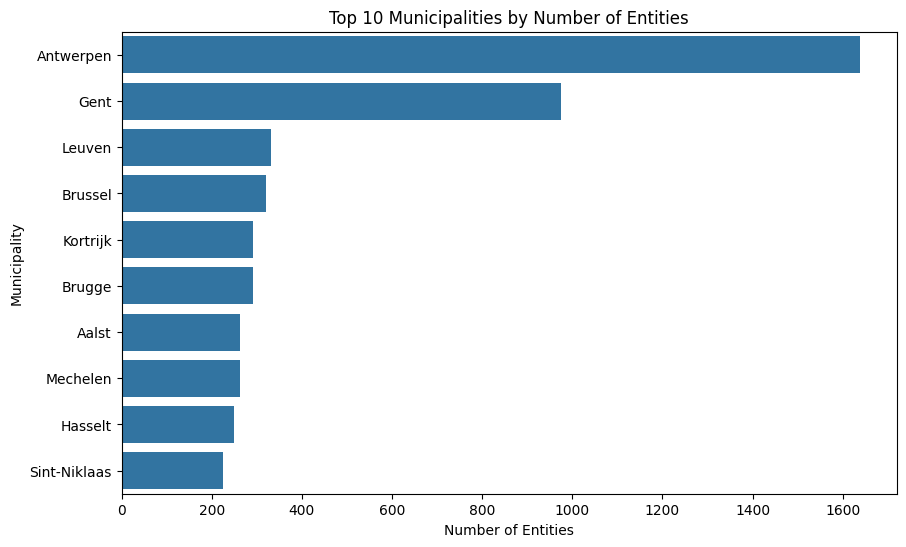

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics for numerical columns and info
print(df_final.describe())
print(df_final.info())

# Count of non-null values to assess missing data
print(df_final.count())

# Frequency of categories in 'Municipality'
municipality_counts = df_final['Municipality'].value_counts()
print(municipality_counts.head())  # Top 5 municipalities

# Visualization: Number of Entities per Municipality (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x=municipality_counts.head(10), y=municipality_counts.head(10).index)
plt.xlabel('Number of Entities')
plt.ylabel('Municipality')
plt.title('Top 10 Municipalities by Number of Entities')
plt.show()


# Visualise duplicate entries in row

In [19]:
# Identifying duplicate entries
duplicate_counts = df_final['URL'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]

# Print each duplicate entry and its count
for entry, count in duplicates_only.items():
    print(f"Entry '{entry}' is duplicated {count} times.")

# Count the total number of duplicates (not just distinct duplicate values)
total_duplicates = df_final.duplicated(subset='URL', keep=False).sum()
print(f"\nTotal number of duplicate entries: {total_duplicates}")


Entry 'WWW.EQUANS.BE' is duplicated 53 times.
Entry 'www.storm.be' is duplicated 41 times.
Entry 'www.engie.com' is duplicated 24 times.
Entry 'www.dockx.com' is duplicated 15 times.
Entry 'www.planet-group.be' is duplicated 12 times.
Entry 'www.liantis.be' is duplicated 12 times.
Entry 'www.bakkerijaernoudt.be' is duplicated 9 times.
Entry 'www.benedenti.be' is duplicated 9 times.
Entry 'www.verstraete.biz' is duplicated 8 times.
Entry 'www.equans.be' is duplicated 8 times.
Entry 'www.verelst.be' is duplicated 7 times.
Entry 'www.benjogroup.eu' is duplicated 7 times.
Entry 'aam-solutions.com' is duplicated 7 times.
Entry 'www.valckenier.be' is duplicated 7 times.
Entry 'www.armonea.be' is duplicated 6 times.
Entry 'www.argenta.be' is duplicated 6 times.
Entry 'www.9altitudes.com' is duplicated 6 times.
Entry 'www.vastgoed-degroote.be' is duplicated 6 times.
Entry 'www.kingslizepizza.be' is duplicated 6 times.
Entry 'www.v-bio.ventures' is duplicated 5 times.
Entry 'www.vl-holding.be' 

# Saving the combined dataset

In [20]:
# Define the path for the new combined Parquet file in your directory
new_combined_parquet_file_path = './combined_filtered_dataset.parquet'

# Save the combined DataFrame as a Parquet file
df_final.to_parquet(new_combined_parquet_file_path)

print(f"Combined and filtered DataFrame saved as Parquet file at: {new_combined_parquet_file_path}")

Combined and filtered DataFrame saved as Parquet file at: ./combined_filtered_dataset.parquet


In [21]:
df_final.to_csv('df_final.csv', index=False)